In [24]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "vscode"
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, explode, col, regexp_replace, transform, isnan

spark = SparkSession.builder.appName("LightcastCleanedData").getOrCreate()

# 重新加载处理后的数据
df_cleaned = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").csv("data/lightcast_cleaned.csv")

# 查看数据结构和样本
df_cleaned.show()

+--------------------+-----------------+----------------------+----------+----------+----------+--------+--------------------+--------------------+--------------------+-----------+-------------------+--------------------+--------------------+---------------+----------------+---------+--------------------+--------------------+-------------------+----------------+---------------------+-------------+-------------------+-------------+------------------+---------------+--------------------+--------------------+--------------------+-------------+------+-----------+----------------+-------------------+---------+-----------+--------------------+--------------------+------------------+------+--------------------+-----+--------------------+-----+-------------+---------------+--------------------+---------------+--------------------+------------+--------------------+------------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+-------

In [34]:
df_cleaned.select("ONET", "ONET_NAME", "ONET_2019", "ONET_2019_NAME").show(10, False)

+----------+------------------------------+----------+------------------------------+
|ONET      |ONET_NAME                     |ONET_2019 |ONET_2019_NAME                |
+----------+------------------------------+----------+------------------------------+
|15-2051.01|Business Intelligence Analysts|15-2051.01|Business Intelligence Analysts|
|15-2051.01|Business Intelligence Analysts|15-2051.01|Business Intelligence Analysts|
|15-2051.01|Business Intelligence Analysts|15-2051.01|Business Intelligence Analysts|
|15-2051.01|Business Intelligence Analysts|15-2051.01|Business Intelligence Analysts|
|15-2051.01|Business Intelligence Analysts|15-2051.01|Business Intelligence Analysts|
|15-2051.01|Business Intelligence Analysts|15-2051.01|Business Intelligence Analysts|
|15-2051.01|Business Intelligence Analysts|15-2051.01|Business Intelligence Analysts|
|15-2051.01|Business Intelligence Analysts|15-2051.01|Business Intelligence Analysts|
|15-2051.01|Business Intelligence Analysts|15-2051.01|

In [8]:
from pyspark.sql.functions import col, when
# Create a new column EDU_MATCH, mark it as a match or not
df_compare = df_cleaned.withColumn(
    "EDU_MATCH",
    when(col("ONET") == col("ONET_2019"), "Match").otherwise("Mismatch")
)

df_compare.select("ONET", "ONET_2019", "EDU_MATCH").show(truncate=False)

# 统计不匹配的行数
unmatched_count = df_cleaned.filter(col("MIN_EDULEVELS") != col("EDUCATION_LEVELS")).count()
print(f"Not Match: {unmatched_count}")

+----------+----------+---------+
|ONET      |ONET_2019 |EDU_MATCH|
+----------+----------+---------+
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
+----------+----------+---------+
only showing top 20 rows



Not Match: 0


In [9]:
from pyspark.sql.functions import col, when
# Create a new column EDU_MATCH, mark it as a match or not
df_compare = df_cleaned.withColumn(
    "EDU_MATCH",
    when(col("ONET_NAME") == col("ONET_2019_NAME"), "Match").otherwise("Mismatch")
)

df_compare.select("ONET_NAME", "ONET_2019_NAME", "EDU_MATCH").show(truncate=False)

# 统计不匹配的行数
unmatched_count = df_cleaned.filter(col("MIN_EDULEVELS") != col("EDUCATION_LEVELS")).count()
print(f"Not Match: {unmatched_count}")

+------------------------------+------------------------------+---------+
|ONET_NAME                     |ONET_2019_NAME                |EDU_MATCH|
+------------------------------+------------------------------+---------+
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Busine

Not Match: 0


k = 2, Silhouette Score = 0.4708


k = 3, Silhouette Score = 0.3219


k = 4, Silhouette Score = 0.3688


k = 5, Silhouette Score = 0.4315


k = 6, Silhouette Score = 0.4745


k = 7, Silhouette Score = 0.4339


k = 8, Silhouette Score = 0.4538


k = 9, Silhouette Score = 0.4807


k = 10, Silhouette Score = 0.4697


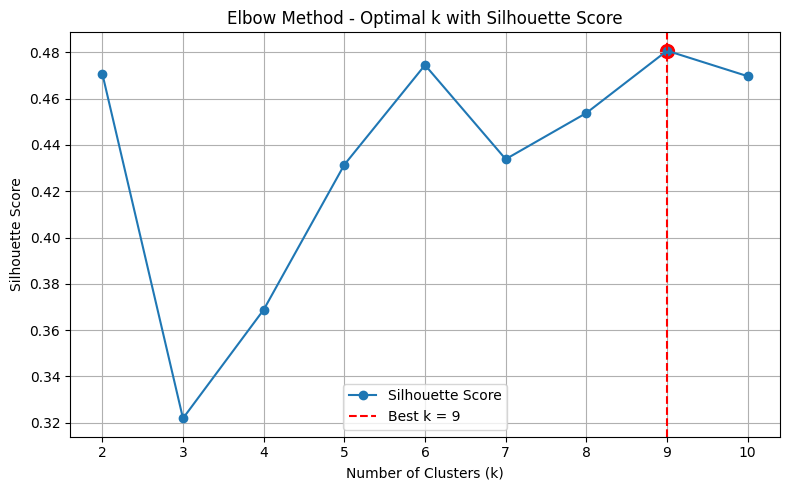

In [27]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt

# === 选择用于聚类的字段 ===
numeric_cols = ["DURATION", "EDUCATION_LEVELS", "SALARY", "SALARY_FROM", "SALARY_TO"]
df_kmeans = df_cleaned.select(numeric_cols + ["TITLE_RAW"]).dropna()

# === 类型转换 ===
for col_name in num_cols:
    df_kmeans = df_kmeans.withColumn(col_name, col(col_name).cast(DoubleType()))

# === 特征组合 + 标准化步骤 ===
assembler = VectorAssembler(inputCols=num_cols, outputCol="raw_features")
scaler = StandardScaler(inputCol="raw_features", outputCol="features", withStd=True, withMean=True)

# === 遍历不同 k 值，收集 silhouette 得分 ===
cost = []
for k in range(2, 11):
    kmeans = KMeans(k=k, seed=688, featuresCol="features")
    pipeline = Pipeline(stages=[assembler, scaler, kmeans])
    model = pipeline.fit(df_kmeans)
    transformed = model.transform(df_kmeans)

    evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="prediction", metricName="silhouette")
    score = evaluator.evaluate(transformed)
    cost.append((k, score))
    print(f"k = {k}, Silhouette Score = {score:.4f}")

# === 找到得分最高的 k ===
best_k, best_score = max(cost, key=lambda x: x[1])

# === 绘制 Elbow 图，并标记最佳 k ===
k_vals, scores = zip(*cost)
plt.figure(figsize=(8, 5))
plt.plot(k_vals, scores, marker='o', label='Silhouette Score')
plt.axvline(x=best_k, color='red', linestyle='--', label=f'Best k = {best_k}')
plt.scatter([best_k], [best_score], color='red', s=100)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Elbow Method - Optimal k with Silhouette Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
# KMeans 模型
kmeans = KMeans(k=9, seed=688, featuresCol="features", predictionCol="cluster")

# 管道构建
pipeline = Pipeline(stages=[assembler, scaler, kmeans])
model = pipeline.fit(df_kmeans)
clustered = model.transform(df_kmeans)

# 收集结果评估
rows = clustered.select("TITLE_RAW", "cluster").collect()
df_clustered = pd.DataFrame([row.asDict() for row in rows])

# sklearn 评估
le = LabelEncoder()
true_labels = le.fit_transform(df_clustered["TITLE_RAW"])
pred_labels = df_clustered["cluster"]

nmi = normalized_mutual_info_score(true_labels, pred_labels)
ari = adjusted_rand_score(true_labels, pred_labels)

df_combined = pd.concat([df_clustered["cluster"], df_kmeans.toPandas()[numeric_cols].reset_index(drop=True)], axis=1)
print(df_combined.groupby("cluster").mean())

print(f"NMI: {nmi:.4f}")
print(f"ARI: {ari:.4f}")

print("TITLE_RAW:")
print(df_clustered.groupby("cluster")["TITLE_RAW"].agg(lambda x: x.value_counts().index[0]))

print("cluster:")
print(df_clustered["cluster"].value_counts().sort_index())

          DURATION  EDUCATION_LEVELS         SALARY    SALARY_FROM  \
cluster                                                              
0        18.161779          1.789782  111256.366887   87767.346831   
1        25.749938          1.527051   65057.507105   56758.813264   
2        47.373626         57.461538  310738.417582  271181.725275   
3        63.121920          2.421036  149805.524953  118837.172142   
4        34.592457         99.000000   74174.511168   63450.519590   
5        33.685156         99.000000  144091.553765  125440.575767   
6        18.666241          1.933631  157585.782706  127086.568283   
7        62.280502          2.292360   95076.877309   74389.932725   
8        43.658933         16.294664  216634.891725  171974.150812   

             SALARY_TO  
cluster                 
0        134367.697824  
1         72444.075044  
2        350295.142857  
3        180567.027479  
4         84139.809960  
5        162684.054540  
6        188054.529036  
7   

In [3]:
# ===== 多元线性回归（标准化版本）=====
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import DoubleType

# 选择字段
lr_df = df_cleaned.select(
    "DURATION", "EDUCATION_LEVELS", "SALARY", "SALARY_FROM", "SALARY_TO"
).dropna()

# 类型转换
num_cols = ["DURATION", "EDUCATION_LEVELS", "SALARY", "SALARY_FROM", "SALARY_TO"]
for col_name in num_cols:
    lr_df = lr_df.withColumn(col_name, col(col_name).cast(DoubleType()))

# 拼接特征向量
assembler = VectorAssembler(
    inputCols=["DURATION", "EDUCATION_LEVELS", "SALARY_FROM", "SALARY_TO"],
    outputCol="assembled_features"
)

# 标准化
scaler = StandardScaler(inputCol="assembled_features", outputCol="features")

# 模型
lr = LinearRegression(featuresCol="features", labelCol="SALARY")

# 划分训练测试集
train_data, test_data = lr_df.randomSplit([0.8, 0.2], seed=42)
train_data = train_data.na.drop(subset=num_cols)
test_data = test_data.na.drop(subset=num_cols)

pipeline = Pipeline(stages=[assembler, scaler, lr])
model = pipeline.fit(train_data)
predictions = model.transform(test_data)

# 评估
evaluator_r2 = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="r2")
evaluator_rmse = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="rmse")

r2 = evaluator_r2.evaluate(predictions)
rmse = evaluator_rmse.evaluate(predictions)

print("\n✅ 多元线性回归结果:")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")


25/04/19 20:42:57 WARN Instrumentation: [c0826b6d] regParam is zero, which might cause numerical instability and overfitting.



✅ 多元线性回归结果:
R²: 0.9991
RMSE: 1340.99
